This notebook contains the code used in order to write this article LINK on climbing Fontainebleau grades.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype
import sqlite3
import re
import sys
import country_converter as coc
from sklearn.neighbors import KernelDensity
import country_converter as coco
import matplotlib.ticker as mtick
import matplotlib
cc = coco.CountryConverter()
matplotlib.style.use('seaborn')
#matplotlib.style.use('ggplot')

Data downloaded from https://www.kaggle.com/dcohen21/8anu-climbing-logbook.

In [2]:
#SQL querries
file='database.sqlite'
cnx = sqlite3.connect(file)

dfAsc = pd.read_sql_query("SELECT * FROM ascent", cnx)
dfGrade = pd.read_sql_query("SELECT * FROM grade",cnx)
dfMethod = pd.read_sql_query("SELECT * FROM method",cnx)
dfUser = pd.read_sql_query("SELECT * FROM USER",cnx)

Below are the function I used to clean and organize the data. I chose to use only ascents that were repeated to avoid data that is more likely to be false. 

In [3]:
def GetContinentSerie(sCountry):
    # continent of users who made the ascent
    #in the country list there are some reserved iso3 not in the dictionnary, I manually replace them where it makes sense\n",
    s=sCountry.replace(to_replace=['ROM','FXX'], value=['ROU','FRA'])
    #Methods from cc are too slow, it's faster to use the replace function from pandas
    s=sCountry.replace(to_replace=cc.data.ISO3.to_list(), value=cc.data.continent.to_list())
    return s

def GradeIdToType(serie,dfGrade,sGradeType='fra_boulders'):
    # convert a grade list from grade_id to sGradeType
    s=serie.replace(dfGrade['id'].tolist(),dfGrade[sGradeType].tolist())
    return s

def InsertUniqueRouteId(df):
    #create a unique route id including the fra_grade
    n_unique_route_id=df['crag']+df['name']
    df.insert(1,'unique_route_id',n_unique_route_id)
    return df

def InsertRepeatedRoute(df):
    #insert only repeated routes
    sOnes=np.ones(df.shape[0])
    df.insert(2,'repeated_route',sOnes)
    vCount=df['unique_route_id'].value_counts()
    unverifiedRoutes=set(vCount[vCount==1].index)
    idxUnverifiedRoutes=df['unique_route_id'].isin(unverifiedRoutes)
    df.loc[idxUnverifiedRoutes,'repeated_route']=0
    return df

def GenerateRepeatedAscentDF(dfAscent):
    #generate a df off all repeated ascents in dfAscent
    #using only repeated routes helps prevent erroneous data
    df=InsertRepeatedRoute(InsertUniqueRouteId(dfAscent))
    df.insert(5,'continent',GetContinentSerie(df['country']))
    return df[df['repeated_route']==1]

def GenerateRouteDF(dfAscent,dfGrade):
    #Generate a dataframe containing routes (instead of ascent of routes)
    dfRouteInfo=dfAscent[['crag','name','country','grade_id','crag_id','sector_id','sector','unique_route_id']]
    vc=dfRouteInfo.value_counts()
    df=vc.index.to_frame()
    df.insert(1,'nb_ascent',vc)
    df=df.set_index('unique_route_id')
    df.insert(1,'fra_boulders',GradeIdToType(df['grade_id'],dfGrade,sGradeType='fra_boulders'))
    df.insert(1,'usa_boulders',GradeIdToType(df['grade_id'],dfGrade,sGradeType='usa_boulders'))
    df.insert(5,'continent',GetContinentSerie(df['country']))
    return df

dfBoulderAsc=dfAsc[dfAsc['climb_type']==1].copy()
dfBoulderAsc=dfBoulderAsc[dfBoulderAsc.grade_id<75]# removing manually every problem with grade =< 9A
dfBoulderAscRepeated=GenerateRepeatedAscentDF(dfBoulderAsc)
dfBoulderProblemRepeated=GenerateRouteDF(dfBoulderAscRepeated,dfGrade)
dfBoulderProblem=GenerateRouteDF(InsertUniqueRouteId(dfAsc[dfAsc['climb_type']==1].copy()),dfGrade)

In [21]:
def CreateDFMaxGrade(dfAscent,dfUser):
    #creates a dataframe containing all maxgrade climbed by users that are present in dfAscent and dfUser
    users=np.intersect1d(np.unique(dfAscent['user_id']),dfUser.id.to_numpy()) #only keep users from ascents that appear in the user dataframe
    dfNp=np.zeros((users.shape[0],2))
    dfNp[:,0]=users
    dfMax=pd.DataFrame(dfNp,columns=['user_id','grade_id'])
    dfMax['country']=""
    dfMax['continent']=""

    for i in range(users.shape[0]):
        dfMax.at[i,'grade_id']=np.max(dfAscent[dfAscent['user_id']==users[i]]['grade_id'])
        dfMax.at[i,'country']=dfUser.set_index(dfUser.id).loc[users[i],'country']
    dfMax.insert(1,'fra_boulders',GradeIdToType(dfMax['grade_id'],dfGrade,sGradeType='fra_boulders'))
    dfMax.insert(1,'usa_boulders',GradeIdToType(dfMax['grade_id'],dfGrade,sGradeType='usa_boulders'))
    dfMax.continent=GetContinentSerie(dfMax.country)
    return dfMax

dfMaxRepeated=CreateDFMaxGrade(dfBoulderAscRepeated,dfUser)

## Sport ascents 
I did some testing to see how sports grade follow the trend I've seen for boulders. You see the same pattern but with less difference. For sport problems 45% percent of the difficulty is occupied by grades with + and 55 by grades without +. I commented out max sport grade because it's long to calculate

In [5]:
dfSportAsc=dfAsc[dfAsc['climb_type']==0].copy()
dfSportAsc=dfSportAsc[dfSportAsc.grade_id<79]# removing manually every problem with grade =< 9A
dfSportAscRepeated=GenerateRepeatedAscentDF(dfSportAsc)
dfSportProblemRepeated=GenerateRouteDF(dfSportAscRepeated,dfGrade)
#dfMaxSport=CreateDFMaxGrade(dfSportAscRepeated,dfUser) # commented out because it's long to calculate

## Distribution of grades
Select the df to draw a graph and calculate it's Kernel density estimation. I used the KDE to get a continous density without curve fitting. I know I expect a rough Gaussian distribution, but the KDE follows the data better and I don't need to know the parameters of this distribution for my analysis. The grade range is specified by the variables minGrade and maxGrade.
 
I tested dfSportProblemRepeated, dfBoulderProblemRepeated or dfMaxSport and the same pattern can be observed on those datasets.

In [17]:
def GraphDistributionAndTrend(serie,minTrendGrade='5A',maxTrendGrade='8C+',minDifferenceGradeOffset=3,maxDifferenceGradeOffset=6,distributionGraphTitle='Max Grade Distribution'):
    """
    #Would be nice to fragment in different function
    -Calculate the KDE of the serie
    -graph the KDE and a bar graph
    -graph the difference between KDE and bar graph
    -calculate the average difference
    """
    #KDE calculations
    minGrade=minTrendGrade
    maxGrade=maxTrendGrade
    s=serie[serie>=minGrade]
    s=s[s<=maxGrade]
    counts=s.value_counts().sort_index().to_numpy()
    counts=counts/np.sum(counts)
    [dataDistribution,uniques]=pd.factorize(s,sort=True)
    minData=np.min(dataDistribution) #=0
    maxData=np.max(dataDistribution)
    nbPoint=2001
    pointPerGrade=(nbPoint-1)/(maxData-minData)
    x = np.linspace(minData, maxData, nbPoint)[:, np.newaxis]
    model = KernelDensity(kernel='gaussian',bandwidth=1)
    model.fit(dataDistribution.reshape(-1, 1))
    dens = np.exp(model.score_samples(x))

    fig, ax1 = plt.subplots()
    # change those 2 parameters to change the grade included in the graph
    xBar=np.arange(minData, maxData+1)
    yBar=counts[np.arange(minData,maxData+1)]
    ax1.bar(xBar,yBar*100,color='cornflowerblue',label='data')
    xDens=np.linspace(minData, maxData, int((maxData)*pointPerGrade))[:, np.newaxis]
    yDens=dens[np.arange(int((minData)*pointPerGrade),int((maxData)*pointPerGrade))]
    ax1.plot(xDens,yDens*100,c='green',label='trend')

    grades=uniques.to_numpy()
    tickSpace=1
    gradeLabels=grades[np.arange(0,grades.shape[0],tickSpace)]
    ax1.set_xticks(np.arange(0,grades.shape[0],tickSpace))
    dump=ax1.set_xticklabels(gradeLabels)
    plt.legend()
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.xlabel('Fontainebleau grade')
    plt.ylabel('Frequency')
    plt.title(distributionGraphTitle)
    dump=plt.xticks(rotation=90)

    #difference graph
    subsetModifMin=minDifferenceGradeOffset #number of grades to ignore starting from min grade and going up, use 3 for starting from 6A
    subsetModifMax=maxDifferenceGradeOffset #number of grades to ignore starting from max grade and going down, use 6 for limiting at 7C+
    xBar=np.arange(minData+subsetModifMin, maxData+1-subsetModifMax)
    yBar=counts[np.arange(minData+subsetModifMin,maxData+1-subsetModifMax)]
    fig, ax = plt.subplots()
    diff=np.zeros(maxData+1-subsetModifMax-subsetModifMin)
    counts2=counts[subsetModifMin:maxData+1-subsetModifMax]
    for i in range(diff.shape[0]):
        diff[i]=((counts2[i])-dens[int((subsetModifMin+i)*pointPerGrade)])/dens[int((subsetModifMin+i)*pointPerGrade)]
    ax.bar(xBar,diff*100,label='difference')
    startLabel=3
    endLabel=grades.shape[0]-6
    gradeLabels2=grades[np.arange(startLabel,endLabel,tickSpace)]
    ax.set_xticks(np.arange(startLabel,endLabel,tickSpace))
    a=ax.set_xticklabels(gradeLabels2)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data',0))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',subsetModifMin-1))
    ax.set_title('Difference between data and trend')
    plt.ylabel('Difference')

    #average difference
    #for this to work the first value in diff needs to be above 5C and without a +
    withoutPlusIndex=np.arange(0,diff.shape[0],2)
    withPlusIndex=np.arange(1,diff.shape[0],2)
    avgWithout=np.mean(diff[withoutPlusIndex])
    avgWith=np.mean(diff[withPlusIndex])
    ratioWithoutPlus=(1+avgWithout)/(1+avgWith+1+avgWithout)
    ratioWithPlus=(1+avgWith)/(1+avgWith+1+avgWithout)
    print('The ratio of difficulty for grades without a + is '+format(ratioWithoutPlus,'.3f')+'\n and the ratio for grades with a + is '+format(ratioWithPlus,'.3f'))
    return [ratioWithoutPlus,ratioWithPlus]

## Distribution graph
Graph containing the distribution of the data and the KDE. The range of the graph can be manipulated by the variables minTrendGrade and maxTrendGrade. By using the full range you can see that the KDE       is not a good estimator for the extreme right. It's too influcenced by previous more numerous data that weight too much compared to the more local one. That's why I recommend not calculating the difference on the full range the trend was calculated on.

## Difference graph
Graph of the difference between the data and the KDE.

$Difference(grade)=\frac{data(grade)-trend(grade)}{trend(grade)}*100$

## Average difficulty difference
I calculate the average difficulty difference between grades with + and without. I restrict this mesure between 6A to 7C+ because my use of the KDE is not appropriate for the data above around 8B. The KDE is too influenced by the largers number on the left which bring it's value way too high compared to the data.

The ratio of difficulty for grades without a + is 0.619
 and the ratio for grades with a + is 0.381


[0.618547338091695, 0.381452661908305]

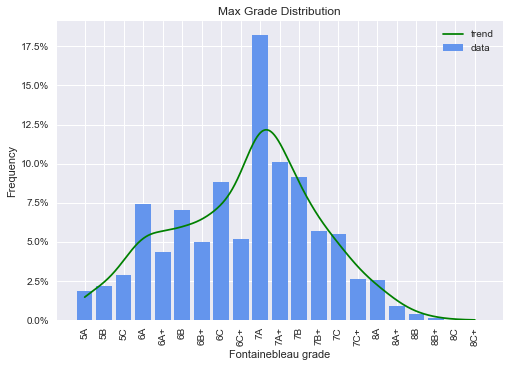

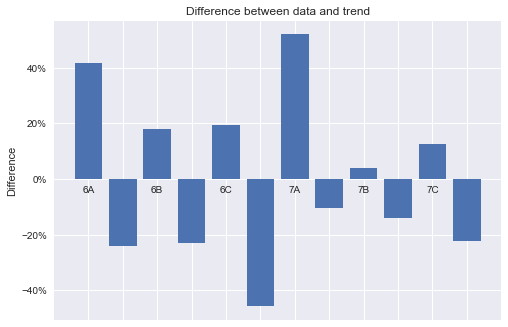

In [20]:
df=dfBoulderProblemRepeated
df=df[df.country!='GBR'] 
df=df[df.continent=='Europe']
serie=df.fra_boulders
GraphDistributionAndTrend(serie,'Boulder Problem Grade Distribution in Europe')

The ratio of difficulty for grades without a + is 0.620
 and the ratio for grades with a + is 0.380


[0.6199607712286106, 0.3800392287713894]

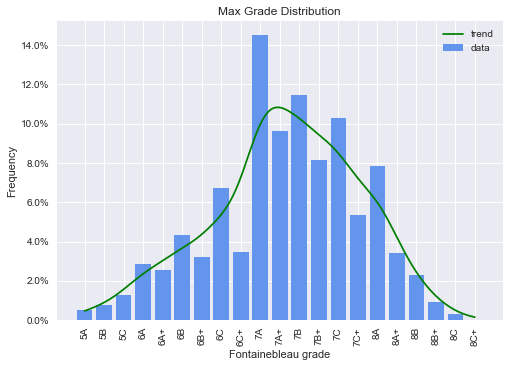

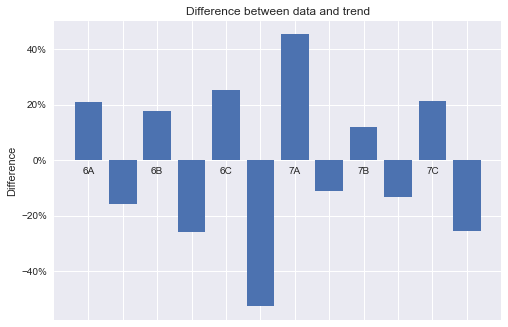

In [22]:
df=dfMaxRepeated
df=df[df.country!='GBR'] 
df=df[df.continent=='Europe']
serie=df.fra_boulders
GraphDistributionAndTrend(serie)

## Explication of the difference between neutral and positive grades
In the article I say that the the difference can be explained by neutral grades containing more difficulties than positive grades. How can we be sure? There are other possibilities. 
### People forget the + when input on the website
That would be a problem and it's hard knowing if it's part of the reason.
### People forgetting the + when writting a guidebook
That would lead to my current conclusion. Even if it's for that reason, in effect neutral grades have a higher difficulty range. 
### People aiming more for neutral grades
This would not explain why we observe the same pattern in the number of boulder problems, so I don't think that's a valid explanation.

## Why is it like that?
I'm not sure. My best explanation is that it's due to how we perceive grades with +. Personnally the + bring's a connotation of "a subpart of something", which sounds smaller than the original something. I verified if the pattern still persisted for sport climbs and it did, altought the difference is smaller then for boulder problems.

In [14]:
def ShowGradeDistribution(df,dfGrade,grade_type='fra_boulders',minGrade='5A'):
    #simpler function to show gradedistribution 
    s=df[grade_type]
    s=s.astype('category')
    s=s.cat.set_categories(dfGrade[grade_type].drop_duplicates().to_list(),ordered=True)
    s=s[s>=minGrade]
    vC=s.value_counts()
    vC=vC[vC!=0]
    vC.sort_index().plot.bar()

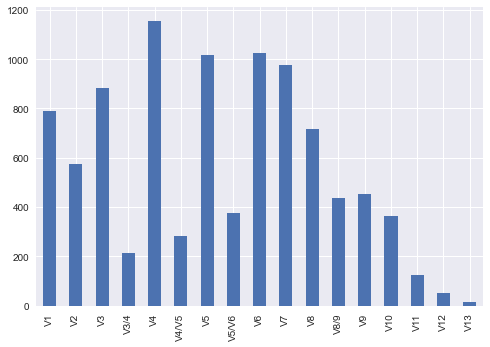

In [29]:
#use of ShowGradeDistribution
df=dfBoulderProblemRepeated
df=df[df.country=='CAN']
ShowGradeDistribution(df,dfGrade,grade_type='usa_boulders',minGrade='V1')